In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
dfppl = pd.read_pickle('./data_intermediate/profile_cleaned.pkl')
dfinfo = pd.read_pickle('./data_intermediate/transactions.pkl')

In [6]:
# Merge the two datasets: transactions & people 
dfinfo = pd.merge(dfinfo, dfppl, on= 'person_id', how= 'left', sort= False)

In [7]:
dfinfo.head(3)

,event,person_id,offer_id,reward_amt,purchase_amt,reward_offer,channels,difficulty,duration,offer_type,day_month,gender,member_year,age,income_thousand
0,offer received,78afa995,9b98b8,0,0.0,5.0,emw,5.0,7.0,bogo,1,F,2017,75.0,100.0
1,offer received,a03223e6,0b1e15,0,0.0,5.0,ew,20.0,10.0,discount,1,None,2017,NaN,NaN
2,offer received,e2127556,2906b8,0,0.0,2.0,emw,10.0,7.0,discount,1,M,2018,68.0,70.0


In [8]:
# I'll keep these transactions as test
dftest = dfinfo.loc[(dfinfo['day_month'] >= 25) & (dfinfo['event'] != 'no offer')]

In [9]:
# I'll use these transactions as training
dftrain = dfinfo.loc[(dfinfo['day_month'] < 25) | (dfinfo['event'] == 'no offer')]

In [10]:
dftest['offer_type'].value_counts()

discount         13292
bogo             13008
informational     4580
Name: offer_type, dtype: int64

In [11]:
dftest['event'].value_counts()

offer received     12765
offer viewed       10314
offer completed     7801
Name: event, dtype: int64

In [12]:
cols_num = ['difficulty', 'duration', 'member_year', 'age', 'income_thousand', 'reward_offer']

cols_cat = ['gender'] # 'channels'

cols = cols_num + cols_cat

In [13]:
# To prevent the error, None > 'F', do the following:
#https://stackoverflow.com/questions/46406720/labelencoder-typeerror-not-supported-between-instances-of-float-and-str
for col in cols_cat:
    dftrain[col] = dftrain[col].astype(str)

<ipython-input-13-60b2ceb583f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain[col] = dftrain[col].astype(str)


In [14]:
# Preprocessing for numerical data
transformer_num = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
transformer_cat = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_num, cols_num),
        ('cat', transformer_cat, cols_cat)
    ])

In [15]:
cls_dt = DecisionTreeClassifier(max_depth = 4, class_weight = 'balanced', criterion = 'entropy')

pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', cls_dt)
])

In [16]:
X_train = dftrain[cols]

target_dict = {'offer received': 0, 'offer viewed': 1, 'offer completed': 2, 'no offer': 3}
y_train = dftrain['event'].replace(target_dict).values

In [17]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['difficulty', 'duration',
                                                   'member_year', 'age',
                                                   'income_thousand',
                                                   'reward_offer']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender'])])),
                ('model',
            

In [18]:
preds_train = pipe.predict(X_train)

confusion_matrix(y_train, preds_train)

array([[ 17372,  12888,  33252,      0],
       [ 11566,  10769,  25076,      0],
       [  3874,    815,  21089,      0],
       [     0,      0,      0, 138953]], dtype=int64)

In [19]:
np.mean(y_train == preds_train)

0.682678285096534

In [20]:
cols_1hot = pipe['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(cols_cat)

In [21]:
dfimportance = pd.DataFrame({'name': cols_num + list(cols_1hot),
                             'importance': pipe['model'].feature_importances_})
# Sort by their importance
dfimportance = dfimportance.sort_values('importance', ascending= False).reset_index()

dfimportance.loc[dfimportance['importance'] > 0]

,index,name,importance
0,1,duration,0.905805
1,5,reward_offer,0.070514
2,8,gender_None,0.017343
3,2,member_year,0.006146
4,4,income_thousand,0.000191


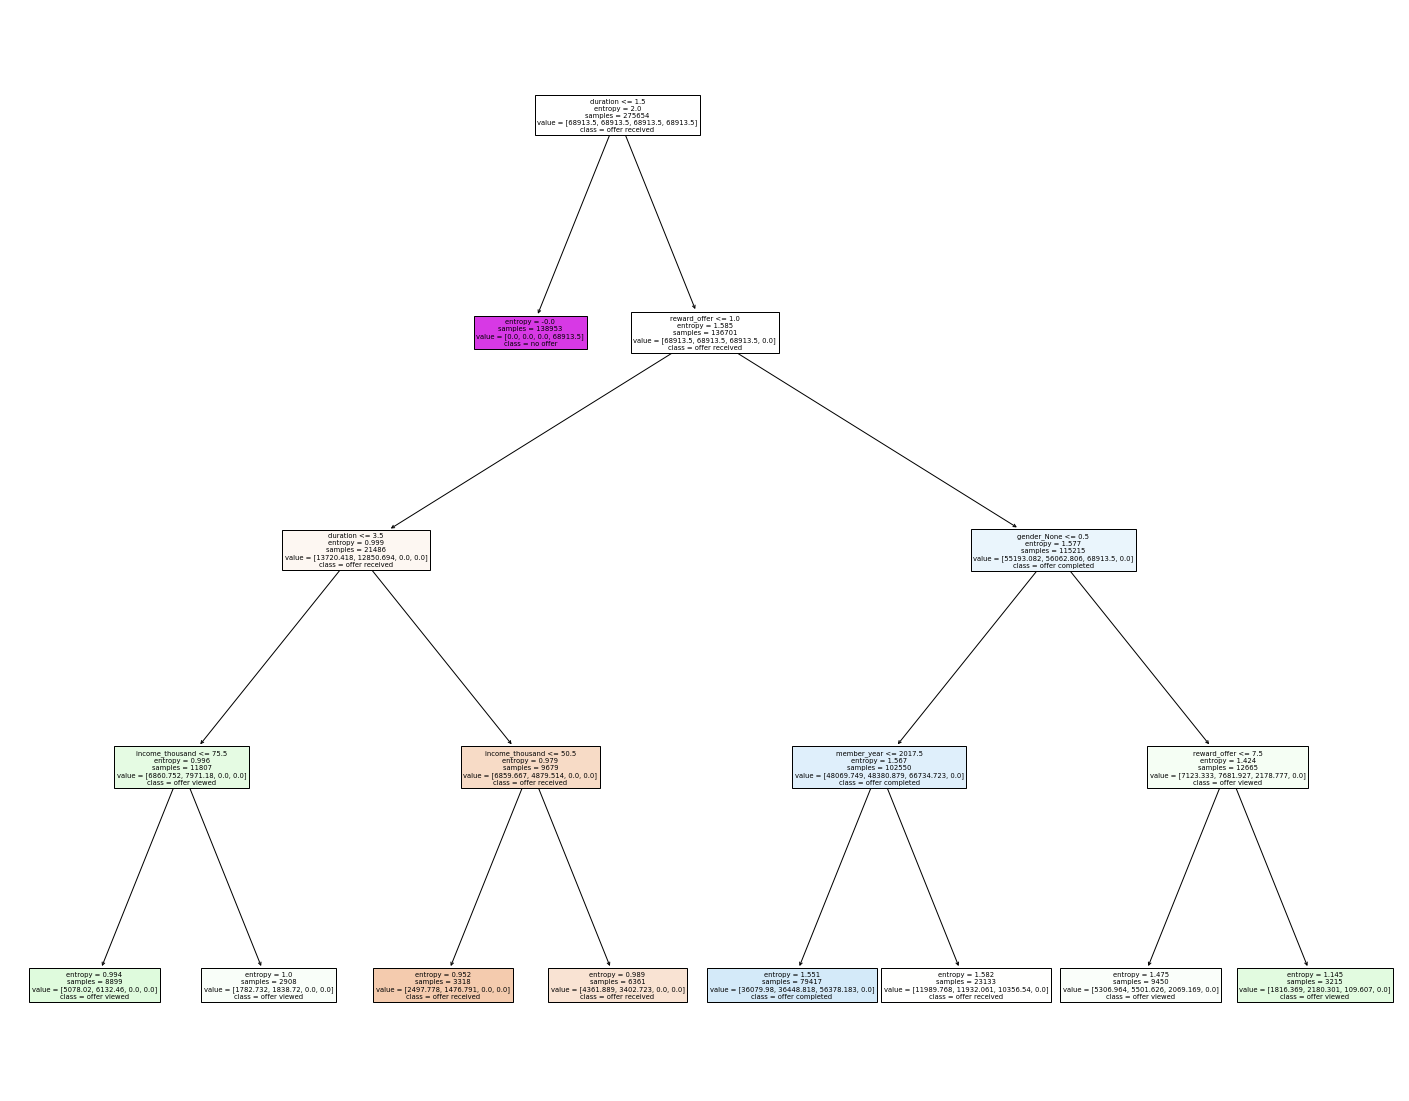

In [22]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(pipe['model'], 
                   feature_names= cols_num + list(cols_1hot),  
                   class_names= ['offer received', 'offer viewed', 'offer completed', 'no offer'],
                   filled= True)


In [23]:
cls_dt = DecisionTreeClassifier(max_depth = 3, class_weight = 'balanced',
                                criterion = 'entropy', splitter = 'random',
                                random_state = 271)

pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', cls_dt)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['difficulty', 'duration',
                                                   'member_year', 'age',
                                                   'income_thousand',
                                                   'reward_offer']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender'])])),
                ('model',
            

In [24]:
preds_train = pipe.predict(X_train)

confusion_matrix(y_train, preds_train)

array([[  6322,  12888,  44302,      0],
       [  3357,  10769,  33285,      0],
       [     0,    815,  24963,      0],
       [     0,      0,      0, 138953]], dtype=int64)

In [25]:
# Accuracy
np.mean(y_train == preds_train)

0.6566456499814985

In [26]:
dfimportance = pd.DataFrame({'name': cols_num + list(cols_1hot),
                             'importance': pipe['model'].feature_importances_})
# Sort by their importance
dfimportance = dfimportance.sort_values('importance', ascending= False).reset_index()

dfimportance.loc[dfimportance['importance'] > 0]

,index,name,importance
0,0,difficulty,0.644986
1,1,duration,0.331312
2,8,gender_None,0.017460
3,2,member_year,0.004295
4,5,reward_offer,0.001947


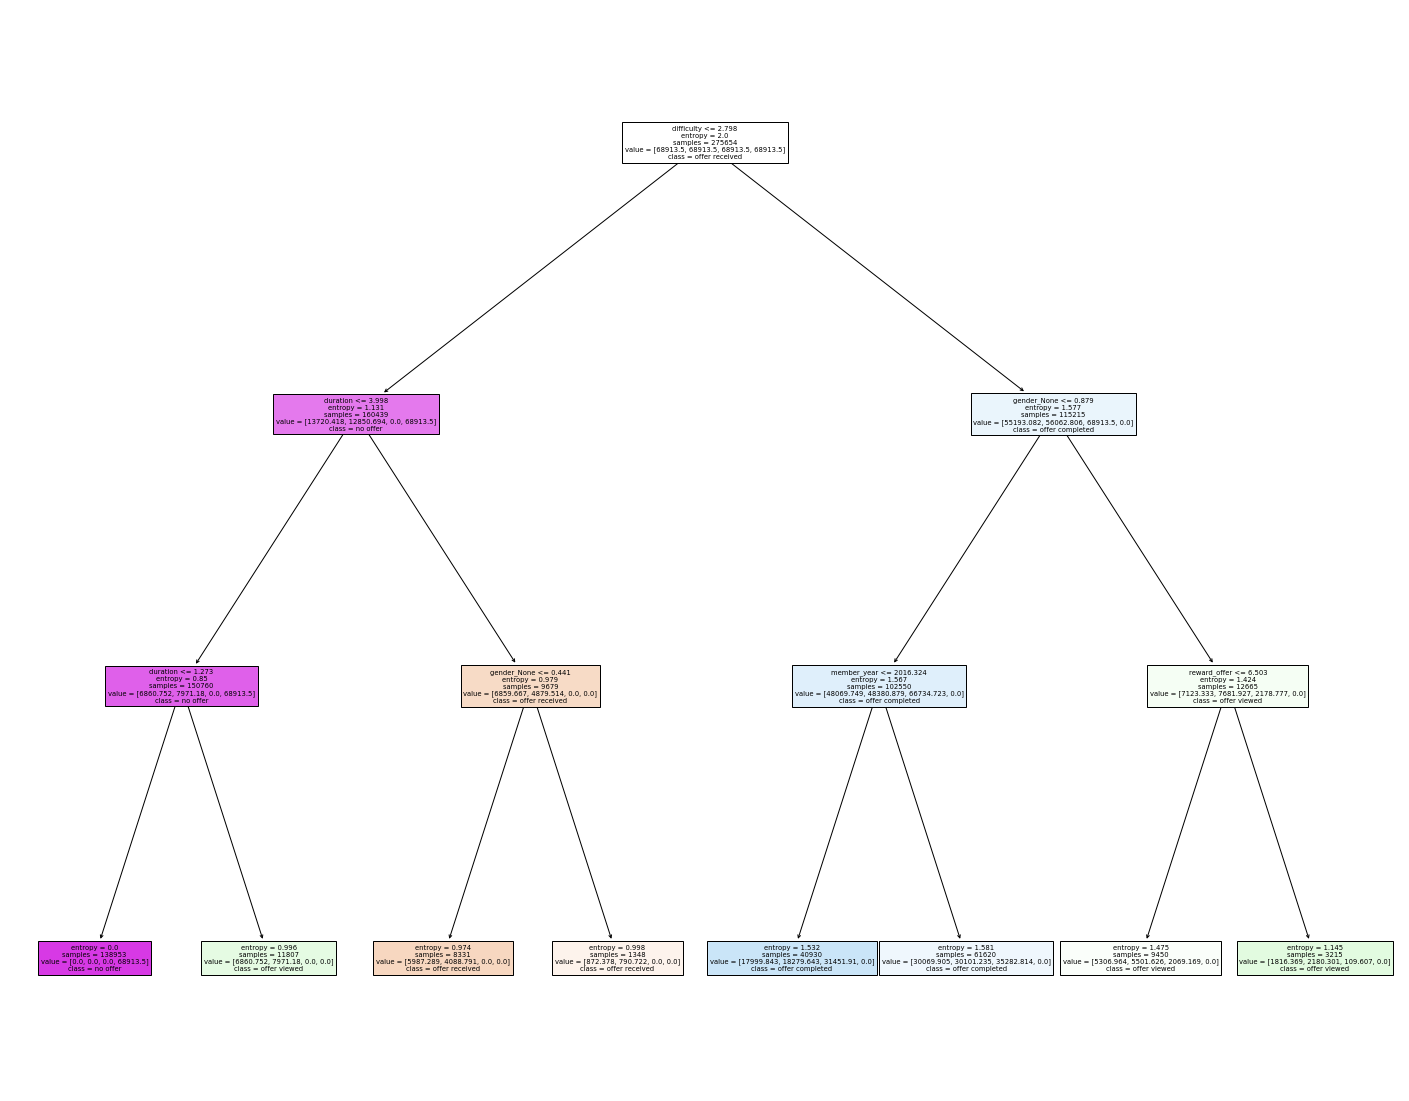

In [27]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(pipe['model'], 
                   feature_names= cols_num + list(cols_1hot),  
                   class_names= ['offer received', 'offer viewed', 'offer completed', 'no offer'],
                   filled= True)


## Model Validation

In [28]:
X_test = dftest[cols]

target_dict = {'offer received': 0, 'offer viewed': 1, 'offer completed': 2, 'no offer': 3}
y_test = dftest['event'].replace(target_dict).values

In [29]:
preds_test = pipe.predict(X_test)

confusion_matrix(y_test, preds_test)

array([[ 1295,  1295, 10175],
       [  787,  1203,  8324],
       [    0,     0,  7801]], dtype=int64)

In [30]:
# Accuracy
np.mean(y_test == preds_test)

0.33351683937823834

In [31]:
# The benchmark, so to speak, 
dftest['event'].value_counts()

offer received     12765
offer viewed       10314
offer completed     7801
Name: event, dtype: int64

I'm disappointed with the result, although accuracy is not my ultimate goal, but just beating the benchmark - accuracy just barely above 1/3 - is not good at all.